## Working with DateTime fields

In [49]:
library(plyr)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(tibble)
library(chron)
library(ISLR)
library(tree)
library(rsample)  # data splitting 
library(dplyr)    # data transformation
library(ggplot2)  # data visualization
library(caret)    # implementing with caret
library(h2o)      # implementing with h2o
library(klaR)

#options(stringsAsFactors = FALSE)

In [50]:
CrimeData = read.csv("NYPD_Complaint_Data_Current__Year_To_Date_.csv")

In [155]:
CD <- data.frame(CrimeData[1:300000,])

CD$ADDR_PCT_CD  <- as.factor(CD$ADDR_PCT_CD)
CD$ReportedDate <- mdy(CD$CMPLNT_TO_DT)

CD$ReportedDate <- as.Date(CD$ReportedDate)

CD$ReportedTime <- CD$CMPLNT_FR_TM
CD$ReportedTime <- chron(times=CD$ReportedTime)

CD$CMPLNT_FR_DT <- NULL
CD$CMPLNT_TO_DT <- NULL

In [156]:
CrimesAgainstBusiness    <- CD[CD$VIC_SEX == 'D',]
CrimesAgainstPeopleOfNYS <- CD[CD$VIC_SEX == 'E',]
CrimesAgainstPersons     <- CD[CD$VIC_SEX == 'M' | CD$VIC_SEX == 'F',]

## Temporary T Dataset for Pre-Processing and Visualization

In [157]:
T <- data.frame(
    Precinct        = CrimesAgainstPersons$ADDR_PCT_CD,
    OffenseDesc     = CrimesAgainstPersons$OFNS_DESC,
    VicSex          = CrimesAgainstPersons$VIC_SEX,
    VicRace         = CrimesAgainstPersons$VIC_RACE,
    VicAgeGroup     = CrimesAgainstPersons$VIC_AGE_GROUP,
    ReportedDate    = CrimesAgainstPersons$ReportedDate,
    ReportedTime    = CrimesAgainstPersons$ReportedTime,
    Borough         = CrimesAgainstPersons$BORO_NM,
    PremisesType    = CrimesAgainstPersons$PREM_TYP_DESC,
    SusAgeGroup     = CrimesAgainstPersons$SUSP_AGE_GROUP,
    SusRace         = CrimesAgainstPersons$SUSP_RACE,
    SusSex          = CrimesAgainstPersons$SUSP_SEX,
    Latitude        = CrimesAgainstPersons$Latitude,
    Longitude       = CrimesAgainstPersons$Longitude
)

VIC_BizOrg         = ifelse(T$VicSex == "D", 1,0)
VIC_PPLOfNYS       = ifelse(T$VicSex == "E", 1,0)

# Convert Column Types
T$OffenseDesc <- as.factor(T$OffenseDesc)
T$ReportedDate <- as.POSIXlt(T$ReportedDate)

T <- na.omit(T)

# Remove all records older than 2020-01-01
T <- subset(T, T$ReportedDate > ("2019-12-31"))

# Add month column

T$Month = rep(0, nrow(T))

T$Month <- as.POSIXlt(T$ReportedDate)
T$Month <- format(as.Date(T$Month), "%B")

T <- na.omit(T)
T <- T[order(as.Date(T$ReportedDate)),]

# Adding a Week column
T$Week = rep(0, nrow(T))
T$Week <- strftime(T$ReportedDate, format = "%V")

# Adding a  Day Of Week column
T$DayOfWeek = rep(0, nrow(T))
T$DayOfWeek <- strftime(T$ReportedDate, format = "%A")

# Add an hour column
T$ReportedTime <- as.factor(T$ReportedTime)

T$Hour = rep(0, nrow(T))
T$Hour <- format(as.POSIXct(T$ReportedTime,format="%H:%M:%S"),"%H")

T <- na.omit(T)

### NYPD - Processing Ready Dataset

In [158]:
# Create Final Processing Ready Dataset

NYPD <- T

NYPD <- na.omit(NYPD)

NYPD$PremisesType      <- as.factor(NYPD$PremisesType)
NYPD$Borough           <- as.factor(NYPD$Borough)

# Cleaning dataset
NYPD <- na.omit(NYPD)

## Cleaning location data
NYPD <- subset(NYPD, 
               Borough == "BROOKLYN" |
               Borough == "BRONX"|
               Borough == "QUEENS" |
               Borough == "STATEN ISLAND" |
               Borough == "MANHATTAN"
              )

NYPD$Borough <- droplevels(NYPD$Borough)

NYPD <- subset(NYPD,
               PremisesType == "RESIDENCE - APT. HOUSE" |
               PremisesType == "STREET" |
               PremisesType == "RESIDENCE-HOUSE" |
               PremisesType == "RESIDENCE - PUBLIC HOUSING" |
               PremisesType == "OTHER" |
               PremisesType == "GROCERY/BODEGA" |
               PremisesType == "COMMERCIAL BUILDING" |
               PremisesType == "PARK/PLAYGROUND" |
               PremisesType == "RESTAURANT/DINER"|
               PremisesType == "HOTEL/MOTEL" |
               PremisesType == "CHAIN STORE" |
               PremisesType == "HOMELESS SHELTER" |
               PremisesType == "PARKING LOT/GARAGE (PUBLIC" |
               PremisesType == "FAST FOOD" |
               PremisesType == "HOSPITAL" |
               PremisesType == "PARKING LOT/GARAGE (PRIVATE)" |
               PremisesType == "BAR/NIGHT CLUB" |
               PremisesType == "DEPARTMENT STORE" |
               PremisesType == "PUBLIC SCHOOL" |
               PremisesType == "BANK" |
               PremisesType == "BUS (NYC TRANSIT)" |
               PremisesType == "PUBLIC BUILDING" |
               PremisesType == "FOOD SUPERMARKET" |
               PremisesType == "DRUG STORE" |
               PremisesType == "HIGHWAY/PARKWAY" |
               PremisesType == "GAS STATION" |
               PremisesType == "DRY CLEANER/LAUNDRY" |
               PremisesType == "DOCTOR/DENTIST OFFICE"               
              )

NYPD$PremisesType <- droplevels(NYPD$PremisesType)

## CLEANING VICTIM DATA
NYPD <- subset(NYPD, 
               VicAgeGroup == "<18" |
               VicAgeGroup == "18-24" |
               VicAgeGroup == "25-44" |
               VicAgeGroup == "45-64" |
               VicAgeGroup == "65+" |
               VicAgeGroup == "UNKNOWN"
              )

NYPD$VicAgeGroup <- droplevels(NYPD$VicAgeGroup)

NYPD <- subset(NYPD, VicSex == "M" | VicSex == "F")
NYPD$VicSex <-droplevels(NYPD$VicSex)

NYPD <- subset(NYPD,
               VicRace == "AMERICAN INDIAN/ALASKAN NATIVE" |
               VicRace == "ASIAN / PACIFIC ISLANDER" |
               VicRace == "BLACK" |
               VicRace == "BLACK HISPANIC" |
               VicRace == "WHITE HISPANIC" |
               VicRace == "WHITE" |
               VicRace == "UNKNOWN"
              )

NYPD$VicRace <- droplevels(NYPD$VicRace)

## CLEANING SUSPECT DATA
NYPD <- subset(NYPD, 
               Borough == "BROOKLYN" |
               Borough == "BRONX"|
               Borough == "QUEENS" |
               Borough == "STATEN ISLAND" |
               Borough == "MANHATTAN"
              )

NYPD$Borough <- droplevels(NYPD$Borough)

## CLEANING SUSPECT DATA
NYPD <- subset(NYPD, 
               SusAgeGroup == "<18" |
               SusAgeGroup == "18-24" |
               SusAgeGroup == "25-44" |
               SusAgeGroup == "45-64" |
               SusAgeGroup == "65+"   |
               SusAgeGroup == "UNKNOWN"
              )

NYPD$SusAgeGroup <- droplevels(NYPD$SusAgeGroup)

NYPD <- subset(NYPD, SusSex == "M" | SusSex == "F")
NYPD$SusSex <-droplevels(NYPD$SusSex)

NYPD <- subset(NYPD,
               SusRace == "AMERICAN INDIAN/ALASKAN NATIVE" |
               SusRace == "ASIAN / PACIFIC ISLANDER" |
               SusRace == "BLACK" |
               SusRace == "BLACK HISPANIC" |
               SusRace == "WHITE HISPANIC" |
               SusRace == "WHITE" |
               SusRace == "UNKNOWN"
              )
NYPD$SusRace <- droplevels(NYPD$SusRace)


NYPD <- subset(NYPD, 
               OffenseDesc == "HARRASSMENT 2" |
               #OffenseDesc == "FELONY ASSAULT"|
               OffenseDesc == "CRIMINAL MISCHIEF & RELATED OF"|
               OffenseDesc == "GRAND LARCENY"|
               OffenseDesc == "OFF. AGNST PUB ORD SENSBLTY &"|
               OffenseDesc == "ROBBERY"|
               OffenseDesc == "VEHICLE AND TRAFFIC LAWS"|
               OffenseDesc == "SEX CRIMES"|
               OffenseDesc == "OFFENSES AGAINST PUBLIC ADMINI"|
               OffenseDesc == "THEFT-FRAUD"|
               OffenseDesc == "RAPE"|
               OffenseDesc == "CRIMINAL TRESPASS"|
               OffenseDesc == "FRAUDS"|
               OffenseDesc == "UNAUTHORIZED USE OF A VEHICLE"|
               OffenseDesc == "ADMINISTRATIVE CODE"
              )

NYPD$Hour       <- as.numeric(NYPD$Hour)
NYPD$Month      <- as.factor(NYPD$Month)
NYPD$Week       <- as.numeric(NYPD$Week)
NYPD$DayOfWeek  <- as.factor(NYPD$DayOfWeek)
NYPD$Precinct   <- as.factor(NYPD$Precinct)

NYPD$Harrassment   = ifelse(NYPD$OffenseDesc == "HARRASSMENT 2", "YES", "NO")
NYPD$Harrassment <- as.factor(NYPD$Harrassment)

NYPD$OffenseDesc <- droplevels(NYPD$OffenseDesc)

NYPD           <- as.data.frame(NYPD)
rownames(NYPD) <- NULL


NYPD$ReportedDate <- NULL
NYPD$ReportedTime <- NULL
NYPD$OffenseDesc  <- NULL
#NYPD$Latitude     <- NULL
#NYPD$Longitude    <- NULL
#NYPD$Week         <- NULL
#NYPD$Hour         <- NULL



# Cleaning dataset
NYPD <- na.omit(NYPD)


## Creating Training and Validation Datasets

In [159]:
## 75% of the sample size
smp_size <- floor(0.75 * nrow(NYPD))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(NYPD)), size = smp_size, replace = TRUE)

train <- NYPD[train_ind, ]
test  <- NYPD[-train_ind, ]

rownames(train) <- NULL
rownames(test) <- NULL

dim(train)
dim(test)

[1] 47482    16

[1] 29976    16

## Naive Bayes Classifier

In [160]:
summary(NYPD)
rbind(sapply(NYPD, class))
#sapply(test, class)

    Precinct     VicSex                              VicRace     
 75     : 2120   F:39267   AMERICAN INDIAN/ALASKAN NATIVE:  278  
 40     : 1782   M:24043   ASIAN / PACIFIC ISLANDER      : 5603  
 47     : 1515             BLACK                         :23823  
 48     : 1514             BLACK HISPANIC                : 3570  
 46     : 1464             UNKNOWN                       : 2506  
 114    : 1419             WHITE                         :11692  
 (Other):53496             WHITE HISPANIC                :15838  
  VicAgeGroup             Borough                          PremisesType  
 <18    : 3255   BRONX        :13588   RESIDENCE - APT. HOUSE    :22142  
 18-24  : 7711   BROOKLYN     :19186   STREET                    :13745  
 25-44  :31293   MANHATTAN    :12693   RESIDENCE-HOUSE           :10817  
 45-64  :16719   QUEENS       :15001   RESIDENCE - PUBLIC HOUSING: 7785  
 65+    : 3611   STATEN ISLAND: 2842   OTHER                     : 1374  
 UNKNOWN:  721              

Precinct,VicSex,VicRace,VicAgeGroup,Borough,PremisesType,SusAgeGroup,SusRace,SusSex,Latitude,Longitude,Month,Week,DayOfWeek,Hour,Harrassment
factor,factor,factor,factor,factor,factor,factor,factor,factor,numeric,numeric,factor,numeric,factor,numeric,factor


In [161]:
#VicSex, VicRace, VicAgeGroup, Borough, PremisesType, SusAgeGroup, SusRace, SusSex, Latitude, Longitude, Month, Week, DayOfWeek,Hour, Harrassment

## K-Means Clustering for Geospatial data

In [162]:
# Preparing the data

x <- CrimesAgainstPersons$X_COORD_CD
y <- CrimesAgainstPersons$Y_COORD_CD

x = na.omit(x)
y = na.omit(y)

points <- data.frame(x, y)

points <- na.omit(points)
points = scale(points)

rownames(points) <- NULL
colnames(points) <- NULL

head(points)


-0.1359701,-0.6770299
0.5141036,1.6333037
0.6673512,-0.8472212
-3.1709762,-1.1777577
1.9932253,-1.6111127
-1.2916773,-1.2679862


In [163]:
# K-Means Cluster Analysis
ClusterInfo = kmeans(points,2)

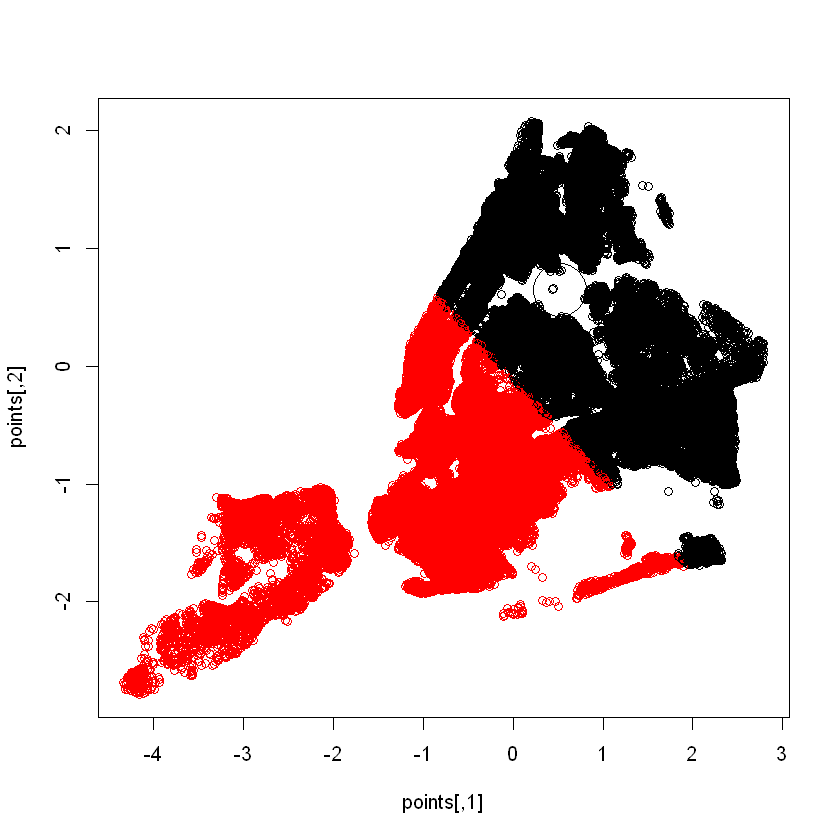

In [164]:
plot(points, col = ClusterInfo$cluster)
points(ClusterInfo$centers, col = 1:3, pch = 1, cex = 6)

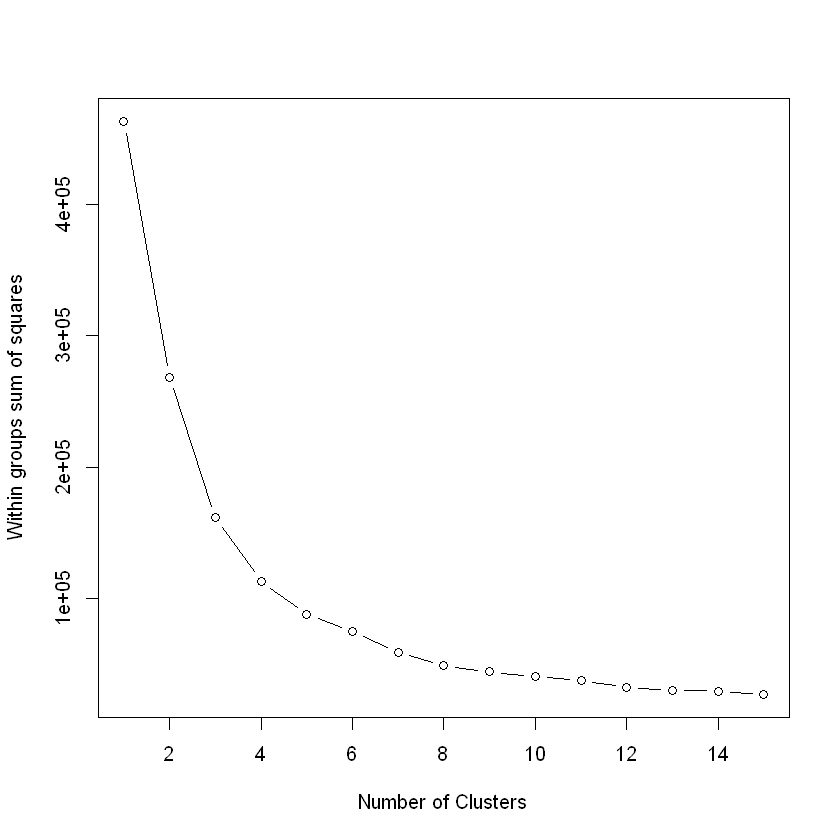

In [165]:
# find the variance 
TheVariance=apply(points,2,var)

# find the sum of squares for 1 cluster
WithinClusterSumOfSquares = (nrow(points)-1)*sum(TheVariance)

# find the sum of squares for 2 to 15 clusters
for (i in 2:15) {
  ClusterInfo=kmeans(points, centers=i)
  WithinClusterSumOfSquares[i] = sum(ClusterInfo$withinss)
}
# plut the result
plot(1:15, WithinClusterSumOfSquares, type="b", xlab="Number of Clusters",ylab="Within groups sum of squares")

In [166]:
# Optimal Number of clusters is between 8 and 12

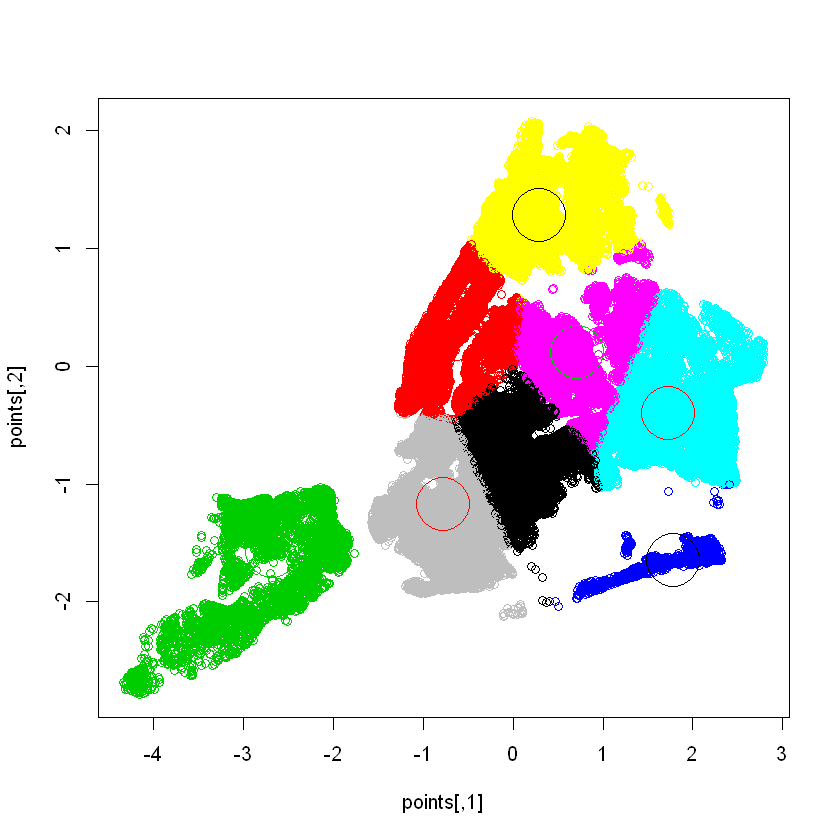

In [167]:
ClusterInfo = kmeans(points,8)
plot(points, col = ClusterInfo$cluster)
points(ClusterInfo$centers, col = 1:3, pch = 1, cex = 6)

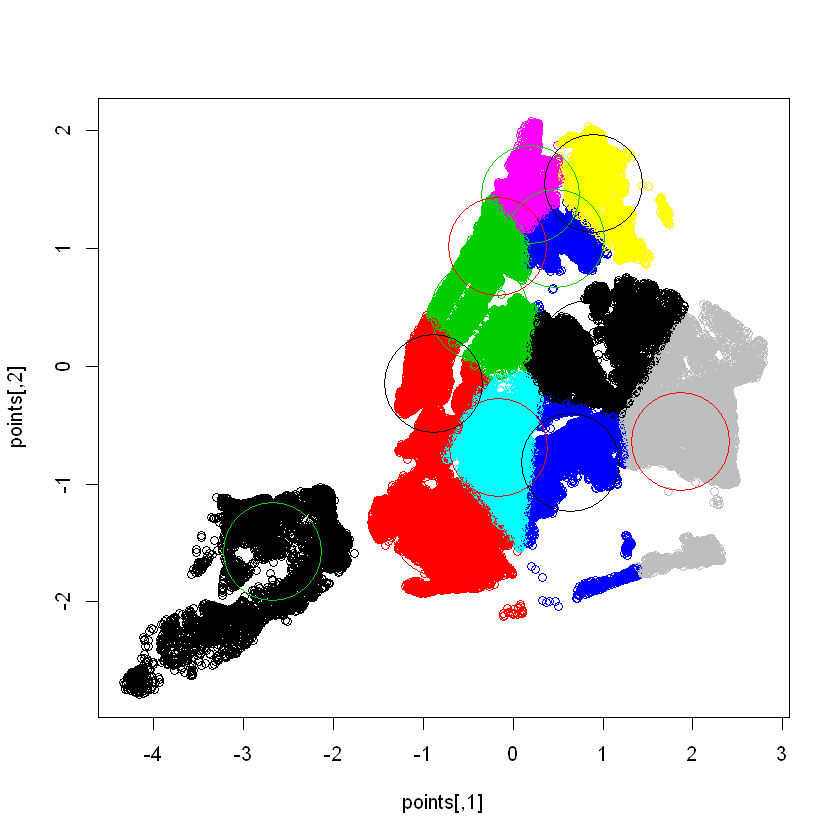

In [168]:
ClusterInfo = kmeans(points,12)
plot(points, col = ClusterInfo$cluster)
points(ClusterInfo$centers, col = 1:3, pch = 1, cex = 11)

In [169]:
## Hierarchical Cluster

In [170]:
d = dist(as.matrix(points))   # find distance matrix
hc = hclust(d)                # apply hirarchical clustering
plot(hc)                       # plot the dendrogram 



#Convert the data matrix into a data frame with x,y coordinate values
#TheDataFrame <- data.frame(x=coordinates(TheData)[,1],y=coordinates(TheData)[,2])

# Find the distance matrix between the points
distances=dist(points)

# Find the hierarchical clusters (tree)
TheTree=hclust(distances)
plot(TheTree)

ERROR: Error: cannot allocate vector of size 199.7 Gb


In [171]:
head(CrimesAgainstPersons)

,ï..CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_TM,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,...,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New.Georeferenced.Column,ReportedDate,ReportedTime
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,...,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<fct>,<fct>,<date>,<times>
1,972326799,81,,21:27:00,,COMPLETED,,,NA,N.Y. POLICE DEPT,...,BLACK,M,1003904,186483,40.67852,-73.92914,"(40.67851591200008, -73.92914304899993)",POINT (-73.92914304899993 40.67851591200008),NA,21:27:00
2,376304873,52,,19:13:00,,COMPLETED,,,NA,N.Y. POLICE DEPT,...,BLACK HISPANIC,M,1017928,258050,40.87491,-73.87822,"(40.87490600500007, -73.87822380899996)",POINT (-73.87822380899996 40.87490600500007),NA,19:13:00
3,299326203,75,,01:21:00,,COMPLETED,,,NA,N.Y. POLICE DEPT,...,BLACK,M,1021234,181211,40.66399,-73.86669,"(40.66399002800006, -73.86669235099998)",POINT (-73.86669235099998 40.66399002800006),NA,01:21:00
4,674946147,121,,08:46:00,,COMPLETED,,,NA,N.Y. POLICE DEPT,...,BLACK,M,938430,170972,40.63584,-74.16509,"(40.63584491100005, -74.165090337)",POINT (-74.165090337 40.63584491100005),NA,08:46:00
5,416422620,101,,13:50:00,,COMPLETED,,,NA,N.Y. POLICE DEPT,...,BLACK,M,1049837,157548,40.59887,-73.76382,"(40.59887464700005, -73.76382298499993)",POINT (-73.76382298499993 40.59887464700005),NA,13:50:00
6,119130081,68,,06:50:00,,COMPLETED,,,NA,N.Y. POLICE DEPT,...,WHITE,M,978972,168177,40.62829,-74.01902,"(40.62829017100006, -74.01901584699993)",POINT (-74.01901584699993 40.62829017100006),NA,06:50:00
